### Stage IV: Basic Machine Learning

In [4]:
import pandas as pd
import functions
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import seaborn as sns
from scipy import stats

In [5]:
deaths = pd.read_csv(r"C:\Users\lorv1\OneDrive\Documents\405\Fall2024DataScience-Group2-ClassProject\Stage I - Data and Project Understanding\Task 3 - Victor\covid_deaths_usafacts.csv")
cases = pd.read_csv(r"C:\Users\lorv1\OneDrive\Documents\405\Fall2024DataScience-Group2-ClassProject\Stage I - Data and Project Understanding\Task 3 - Victor\covid_confirmed_usafacts.csv")
population = pd.read_csv(r"C:\Users\lorv1\OneDrive\Documents\405\Fall2024DataScience-Group2-ClassProject\Stage II - Data Modeling\Victor\covid_county_population_usafacts.csv")
census = pd.read_csv(r"C:\Users\lorv1\OneDrive\Documents\405\Fall2024DataScience-Group2-ClassProject\Stage I - Data and Project Understanding\Task 3 - Victor\census_by_county.csv", low_memory=False, skiprows=0)

Function to get the column description

In [7]:
column_descriptions = census.iloc[0]  

# Get the column names
column_names = census.columns

# Create a dictionary mapping column names to descriptions
column_map = dict(zip(column_names, column_descriptions))

def get_description(column_name):
    """Get the description for a given column name."""
    return column_map.get(column_name, "Description not found")

column_name = "DP05_0087PE"  
get_description(column_name)

'Percent!!CITIZEN, VOTING AGE POPULATION!!Citizen, 18 and over population'

We will need to find the top 5 counties in Washington with the most COVID-19 cases

In [9]:
# Get the Weekly sum of all the counties
wa_weekly_county = functions.sum_by_county_weekly(cases,'WA')
wa_weekly_county = wa_weekly_county.drop(columns='countyFIPS')

# Keep County Name columns
county_names = wa_weekly_county.iloc[:,:1]
wa_weekly_county = wa_weekly_county.drop(columns='County Name')

# Create empty series
row_sums = pd.Series(index=wa_weekly_county.index)

# Save the row total in the series
for i, row in wa_weekly_county.iterrows():
    row_sums[i] = row.sum(numeric_only=True)

sums = pd.DataFrame(row_sums)
full_county = pd.concat([county_names,sums],axis=1)

# Rename and sort descending
full_county.rename(columns={0: "Total"}, inplace=True)
full_county = full_county.sort_values('Total', ascending=False)
top_5 = full_county.iloc[:5,:]
# top_5
# King 5533877, Yakima 2401826, Pierce 2016210 , Snohomish 1830402, Spokane 1813850.

From the above the five counties in Washington with the highest number of cases from 2020.06.01 to 2021.01.03 are King, Yakima, Pierce, Snohomish, and Spokane. <br>
Then filter the cases for the top five counties

In [192]:
wa_cases = cases[cases['State']=='WA'].reset_index(drop= True)
# Save columns and drop
info = wa_cases.iloc[:,:4]
wa_dates = wa_cases.drop(columns=['countyFIPS', 'County Name', 'State','StateFIPS'])

# Target date range
wa_dates = wa_dates.loc[:, (wa_dates.columns >= '2020-06-01') & (wa_dates.columns <= '2021-01-03')]

wa_full = pd.concat([info,wa_dates], axis= 1)

# Select the top five counties
wa_5_cases = wa_full[(wa_full['County Name']=='King County ') | (wa_full['County Name']== 'Yakima County ') | (wa_full['County Name']== 'Pierce County ') | 
(wa_full['County Name']== 'Yakima County ') | (wa_full['County Name']== 'Snohomish County ') | (wa_full['County Name']== 'Spokane County ')].reset_index(drop= True)
wa_5_cases

,countyFIPS,County Name,State,StateFIPS,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05,2020-06-06,...,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,2020-12-31,2021-01-01,2021-01-02,2021-01-03
0,53033,King County,WA,53,8123,8177,8264,8318,8371,8417,...,59383,59383,59383,57783,57783,61148,62580,62580,62580,65265
1,53053,Pierce County,WA,53,1940,1950,1968,1991,2007,2019,...,23914,23914,23914,23114,23114,25070,25864,25864,25864,26839
2,53061,Snohomish County,WA,53,2976,2987,2991,2999,3014,3025,...,20656,20656,20656,19819,19819,21462,22393,22393,22393,23120
3,53063,Spokane County,WA,53,600,612,627,648,664,713,...,23768,23768,23768,23032,23032,24655,25581,25581,25581,26572
4,53077,Yakima County,WA,53,3749,3817,3938,4031,4141,4366,...,18161,18161,18161,17438,17438,19069,19844,19844,19844,20373


Do the same for the deaths

In [13]:
wa_pop = functions.state_population(population,'WA')

In [14]:
fivecol = wa_5_cases.iloc[:,1:2]
wa_5_drop = wa_5_cases.drop(columns=['countyFIPS', 'County Name', 'State', 'StateFIPS'])
wa_5_norm = (wa_5_drop/wa_pop) *10000
wa_5_norm = pd.concat([fivecol,wa_5_norm], axis= 1)
# wa_5_norm

In [15]:
wa_deaths = deaths[deaths['State']=='WA'].reset_index(drop= True)
# Save columns and drop
infod = wa_deaths.iloc[:,:4]
wa_ddates = wa_deaths.drop(columns=['countyFIPS', 'County Name', 'State','StateFIPS'])

# Target date range
wa_ddates = wa_ddates.loc[:, (wa_ddates.columns >= '2020-06-01') & (wa_ddates.columns <= '2021-01-03')]

wa_dfull = pd.concat([infod,wa_ddates], axis= 1)

# Select the top five counties
wa_5_deaths = wa_dfull[(wa_dfull['County Name']=='King County ') | (wa_dfull['County Name']== 'Yakima County ') | (wa_dfull['County Name']== 'Pierce County ') | 
(wa_dfull['County Name']== 'Yakima County ') | (wa_dfull['County Name']== 'Snohomish County ') | (wa_dfull['County Name']== 'Spokane County ')].reset_index(drop= True)
# wa_5_deaths

In [16]:
fivecold = wa_5_deaths.iloc[:,1:2]
wa_5d_drop = wa_5_deaths.drop(columns=['countyFIPS', 'County Name', 'State', 'StateFIPS'])
wa_5d_norm = (wa_5d_drop/wa_pop) *10000
wa_5_normd = pd.concat([fivecold,wa_5d_norm], axis= 1)
# wa_5_normd

For the census (demographics) Fill in missing values with NaN for easier data manipulation. Filter for Washington

In [18]:
pd.set_option('future.no_silent_downcasting', True)
wa_census = census[census['NAME'].str.contains(", Washington", case=True)]
wa_census = wa_census.drop(census.columns[-1], axis=1)
wa_census = wa_census.replace('*****', np.NaN)
wa_census = wa_census.replace('(X)', np.NaN)

cols_needed = ['E']
wa_e = wa_census.loc[:,wa_census.columns.str.contains('|'.join(cols_needed))].reset_index(drop=True)
wa_e_col = wa_e.iloc[:,:2]
wa_e = wa_e.drop(columns=['GEO_ID', 'NAME'])
wa_e= wa_e.dropna(axis=1, how='all')
wa_e = wa_e.apply(pd.to_numeric, errors='coerce')

wa_e_full = pd.concat([wa_e_col, wa_e], axis= 1)

wa_5_e = wa_e_full[(wa_e_full['NAME'].str.contains("King")) | (wa_e_full['NAME'].str.contains("Yakima")) 
| (wa_e_full['NAME'].str.contains("Pierce")) | (wa_e_full['NAME'].str.contains("Snohomish")) |(wa_e_full['NAME'].str.contains("Spokane"))]

wa_5_e

,GEO_ID,NAME,DP05_0001E,DP05_0002E,DP05_0003E,DP05_0004E,DP05_0005E,DP05_0006E,DP05_0007E,DP05_0008E,...,DP05_0079PE,DP05_0080PE,DP05_0081PE,DP05_0082PE,DP05_0083PE,DP05_0084PE,DP05_0085PE,DP05_0087PE,DP05_0088PE,DP05_0089PE
16,0500000US53033,"King County, Washington",2225064,1117507,1107557,100.9,127885,127809,122340,118842,...,0.5,18.2,0.7,0.4,5.7,0.4,5.3,1524945,49.6,50.4
26,0500000US53053,"Pierce County, Washington",891862,444979,446883,99.6,58992,58864,57475,53578,...,0.9,6.3,1.4,0.3,7.5,0.2,7.3,647820,49.6,50.4
30,0500000US53061,"Snohomish County, Washington",811572,406760,404812,100.5,51382,50311,51680,46357,...,0.8,11.3,0.5,0.4,5.2,0.3,4.9,569891,49.9,50.1
31,0500000US53063,"Spokane County, Washington",513402,254791,258611,98.5,30826,31489,31992,32663,...,1.0,2.2,0.6,0.1,4.5,0.3,4.1,389102,49.1,50.9
38,0500000US53077,"Yakima County, Washington",250649,125145,125504,99.7,20142,20839,21436,18839,...,3.0,0.9,0.5,0.1,2.4,0.2,2.1,147259,48.5,51.5


In [19]:
print(get_description("DP05_0041E"))
print(get_description("DP05_0042E"))

Estimate!!RACE!!Total population!!One race!!American Indian and Alaska Native!!Chippewa tribal grouping
Estimate!!RACE!!Total population!!One race!!American Indian and Alaska Native!!Navajo tribal grouping


List of the top five counties to make it easier to show the graph

In [21]:
top_counties = ['King County ', 'Pierce County ', 'Snohomish County ', 'Spokane County ', 'Yakima County ']

### Functions

In [23]:
# Function to calculate daily new cases
def calculate_new(df, date_columns):
    new_cases_df = df[date_columns].diff(axis=1)
    new_cases_df.iloc[:, 0] = df[date_columns].iloc[:, 0]  
    return new_cases_df

Function to show the regression for cases

In [235]:
# Get  date range (columns in your dataset)
date_columns = wa_5_cases.columns[4:]  

# Calculate new cases per day
new_cases = calculate_new(wa_5_cases, date_columns)
new_cases = new_cases.drop(columns= '2020-06-01')

# Add new cases back to the original DataFrame for each county
df_new_cases = pd.concat([wa_5_cases[['County Name']], new_cases], axis=1)

# Prepare X-axis (days)
days = np.arange(0, len(date_columns)-1)  # X-axis is the number of days

# Function to plot linear and polynomial regression for a county
def regression(county_name, degree=3):
    county_data = df_new_cases[df_new_cases['County Name'] == county_name]
    county_data = county_data.iloc[:, 1:].values.flatten()  # Get new cases for the county
    
    # Linear regression
    X = days.reshape(-1, 1)
    y = county_data
    
    linear_model = LinearRegression()
    linear_model.fit(X, y)
    y_pred_linear = linear_model.predict(X)
    
    # Calculate R-squared for linear regression
    r2_linear = linear_model.score(X, y)
    
    # Polynomial regression
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    poly_model = LinearRegression()
    poly_model.fit(X_poly, y)
    y_pred_poly = poly_model.predict(X_poly)
    
    # Calculate R-squared for polynomial regression
    r2_poly = poly_model.score(X_poly, y)
    
    # RMSE for Linear and Polynomial Models
    rmse_linear = sqrt(mean_squared_error(y, y_pred_linear))
    rmse_poly = sqrt(mean_squared_error(y, y_pred_poly))
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(days, y, color='blue', label='Actual Data')
    plt.plot(days, y_pred_linear, color='green', 
             label=f'Linear (RMSE: {rmse_linear:.2f}, R²: {r2_linear:.2f})')
    plt.plot(days, y_pred_poly, color='red', 
             label=f'Polynomial (Degree {degree}, RMSE: {rmse_poly:.2f}, R²: {r2_poly:.2f})')
    plt.title(f'COVID-19 New Cases per Day ({county_name})')
    plt.xlabel('Days')
    plt.ylabel('Number of New Cases')
    plt.legend()
    # plt.grid(True)
    plt.show()

Regression for deaths

In [27]:
date_columnsd = wa_5_deaths.columns[4:]  

# Calculate new cases per day
new_casesd = calculate_new(wa_5_deaths, date_columnsd)
new_casesd = new_casesd.drop(columns= '2020-06-01')

# Add new cases back to the original DataFrame for each county
df_new_casesd = pd.concat([wa_5_deaths[['County Name']], new_casesd], axis=1)

# X-axis (days)
daysd = np.arange(0, len(date_columnsd)-1)  

# Function to plot linear and polynomial regression for a county
def regression_d(county_name, degree=3):
    county_datad = df_new_casesd[df_new_casesd['County Name'] == county_name]
    county_datad = county_datad.iloc[:, 1:].values.flatten()  # Get new cases for the county
    
    # Linear regression
    X = daysd.reshape(-1, 1)
    y = county_datad
    
    linear_model = LinearRegression()
    linear_model.fit(X, y)
    y_pred_linear = linear_model.predict(X)
    
    # Calculate R-squared for linear regression
    r2_linear = linear_model.score(X, y)
    
    # Polynomial regression
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    poly_model = LinearRegression()
    poly_model.fit(X_poly, y)
    y_pred_poly = poly_model.predict(X_poly)
    
    # Calculate R-squared for polynomial regression
    r2_poly = poly_model.score(X_poly, y)
    
    # RMSE for Linear and Polynomial Models
    rmse_linear = sqrt(mean_squared_error(y, y_pred_linear))
    rmse_poly = sqrt(mean_squared_error(y, y_pred_poly))
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(days, y, color='blue', label='Actual Data')
    plt.plot(days, y_pred_linear, color='green', 
             label=f'Linear (RMSE: {rmse_linear:.2f}, R²: {r2_linear:.2f})')
    plt.plot(days, y_pred_poly, color='red', 
             label=f'Polynomial (Degree {degree}, RMSE: {rmse_poly:.2f}, R²: {r2_poly:.2f})')
    plt.title(f'COVID-19 New Deaths per Day ({county_name})')
    plt.xlabel('Days')
    plt.ylabel('Number of New Deaths')
    plt.legend()
    # plt.grid(True)
    plt.show()

Regression with prediction for deaths

In [29]:
date_columnsd = wa_5_deaths.columns[4:]  

# Calculate new cases per day
new_casesd = calculate_new(wa_5_deaths, date_columnsd)
new_casesd = new_casesd.drop(columns= '2020-06-01')

# Add new cases back to the original DataFrame for each county
df_new_casesd = pd.concat([wa_5_deaths[['County Name']], new_casesd], axis=1)

# X-axis (days)
daysd = np.arange(0, len(date_columnsd)-1) 

# Function to plot linear and polynomial regression for a county
def regression_predictiond(county_name, degree=3):
    county_datad = df_new_casesd[df_new_casesd['County Name'] == county_name]
    county_datad = county_datad.iloc[:, 1:].values.flatten()  # Get new cases for the county
    
    # Linear regression
    X = days.reshape(-1, 1)
    y = county_datad
    
    linear_model = LinearRegression()
    linear_model.fit(X, y)
    y_pred_linear = linear_model.predict(X)
    
    # Calculate R-squared for linear regression
    r2_linear = linear_model.score(X, y)
    
    # Polynomial regression
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    poly_model = LinearRegression()
    poly_model.fit(X_poly, y)
    y_pred_poly = poly_model.predict(X_poly)
    
    # Calculate R-squared for polynomial regression
    r2_poly = poly_model.score(X_poly, y)
    
    # RMSE for Linear and Polynomial Models
    rmse_linear = sqrt(mean_squared_error(y, y_pred_linear))
    rmse_poly = sqrt(mean_squared_error(y, y_pred_poly))

    forecast_days = np.arange(len(days), len(days) + 7).reshape(-1, 1)  # Extend days by 7
    total_days = np.concatenate([days, forecast_days.flatten()])  # Total days including forecast
    
    # Linear regression forecast
    linear_forecast = linear_model.predict(forecast_days)
    y_pred_linear_forecast = np.concatenate([y_pred_linear, linear_forecast])
    
    # Polynomial regression forecast
    forecast_days_poly = poly.transform(forecast_days)
    poly_forecast = poly_model.predict(forecast_days_poly)
    y_pred_poly_forecast = np.concatenate([y_pred_poly, poly_forecast])
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(days, y, color='blue', label='Actual Data')
    plt.plot(days, y_pred_linear, color='green', 
             label=f'Linear (RMSE: {rmse_linear:.2f}, R²: {r2_linear:.2f})')
    plt.plot(days, y_pred_poly, color='red', 
             label=f'Polynomial (Degree {degree}, RMSE: {rmse_poly:.2f}, R²: {r2_poly:.2f})')
    plt.axvline(x=len(days) - 1, color='gray', linestyle='--')  # Mark the start of forecast
    #plt.fill_between(total_days[len(days):], y_pred_poly_forecast[len(days):], color='orange', label='7 Day Prediction')
    plt.plot(total_days[len(days):], y_pred_poly_forecast[len(days):], color='orange', label='7 Day Prediction')

    plt.title(f'COVID-19 New Deaths per Day ({county_name})')
    plt.xlabel('Days')
    plt.ylabel('Number of New Deaths')
    plt.legend()
    # plt.grid(True)
    plt.show()

Function for regression prediction for cases

In [31]:
date_columnspc = wa_5_cases.columns[4:]  

# Calculate new cases per day
new_casespc = calculate_new(wa_5_cases, date_columnspc)
new_casespc = new_casespc.drop(columns= '2020-06-01')

# Add new cases back to the original DataFrame for each county
df_new_casespc = pd.concat([wa_5_cases[['County Name']], new_casespc], axis=1)

# X-axis (days)
dayspc = np.arange(0, len(date_columnspc)-1)

# Function to plot linear and polynomial regression for a county
def regression_predictionc(county_name, degree=3):
    county_data = df_new_casespc[df_new_casespc['County Name'] == county_name]
    county_data = county_data.iloc[:, 1:].values.flatten()  # Get new cases for the county
    
    # Linear regression
    X = dayspc.reshape(-1, 1)
    y = county_data
    
    linear_model = LinearRegression()
    linear_model.fit(X, y)
    y_pred_linear = linear_model.predict(X)
    
    # Calculate R-squared for linear regression
    r2_linear = linear_model.score(X, y)
    
    # Polynomial regression
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    poly_model = LinearRegression()
    poly_model.fit(X_poly, y)
    y_pred_poly = poly_model.predict(X_poly)
    
    # Calculate R-squared for polynomial regression
    r2_poly = poly_model.score(X_poly, y)
    
    # RMSE for Linear and Polynomial Models
    rmse_linear = sqrt(mean_squared_error(y, y_pred_linear))
    rmse_poly = sqrt(mean_squared_error(y, y_pred_poly))

    forecast_days = np.arange(len(dayspc), len(dayspc) + 7).reshape(-1, 1)  # Extend days by 7
    total_days = np.concatenate([dayspc, forecast_days.flatten()])  # Total days including forecast
    
    # Linear regression forecast
    linear_forecast = linear_model.predict(forecast_days)
    y_pred_linear_forecast = np.concatenate([y_pred_linear, linear_forecast])
    
    # Polynomial regression forecast
    forecast_days_poly = poly.transform(forecast_days)
    poly_forecast = poly_model.predict(forecast_days_poly)
    y_pred_poly_forecast = np.concatenate([y_pred_poly, poly_forecast])
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(days, y, color='blue', label='Actual Data')
    plt.plot(days, y_pred_linear, color='green', 
             label=f'Linear (RMSE: {rmse_linear:.2f}, R²: {r2_linear:.2f})')
    plt.plot(days, y_pred_poly, color='red', 
             label=f'Polynomial (Degree {degree}, RMSE: {rmse_poly:.2f}, R²: {r2_poly:.2f})')
    plt.axvline(x=len(days) - 1, color='gray', linestyle='--')  # Mark the start of forecast
    #plt.fill_between(total_days[len(days):], y_pred_poly_forecast[len(days):], color='orange', label='7 Day Prediction')
    plt.plot(total_days[len(dayspc):], y_pred_poly_forecast[len(dayspc):], color='orange', label='7 Day Prediction')

    plt.title(f'COVID-19 New Cases per Day ({county_name})')
    plt.xlabel('Days')
    plt.ylabel('Number of New Cases')
    plt.legend()
    # plt.grid(True)
    plt.show()

Function to calculate confidence interval

In [33]:
def get_confidence_interval(model, X, y_pred, sigma=1.96):
    pred_std = np.std(y_pred)
    lower_bound = y_pred - sigma * pred_std
    upper_bound = y_pred + sigma * pred_std
    return lower_bound, upper_bound

Regression prediction with connfidence interval

In [262]:
# Function to plot linear and polynomial regression for a county
def regression_predictioncCI(county_name, degree=3):
    county_data = df_new_casespc[df_new_casespc['County Name'] == county_name]
    county_data = county_data.iloc[:, 1:].values.flatten()  # Get new cases for the county
    
    # Linear regression
    X = dayspc.reshape(-1, 1)
    y = county_data
    
    linear_model = LinearRegression()
    linear_model.fit(X, y)
    y_pred_linear = linear_model.predict(X)
    
    # Polynomial regression
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    poly_model = LinearRegression()
    poly_model.fit(X_poly, y)
    y_pred_poly = poly_model.predict(X_poly)
    
    # RMSE for Polynomial Model
    rmse_poly = sqrt(mean_squared_error(y, y_pred_poly))
    
    # Forecasting for 7 days ahead
    forecast_days = np.arange(len(dayspc), len(dayspc) + 7).reshape(-1, 1)  # Extend days by 7
    total_days = np.concatenate([dayspc, forecast_days.flatten()])  # Total days including forecast
    forecast_days_poly = poly.transform(forecast_days)
    poly_forecast = poly_model.predict(forecast_days_poly)
    y_pred_poly_forecast = np.concatenate([y_pred_poly, poly_forecast])
    
    # Calculate confidence intervals
    lower_pred, upper_pred = get_confidence_interval(poly_model, X_poly, y_pred_poly)
    lower_pred_forecast, upper_pred_forecast = get_confidence_interval(poly_model, forecast_days_poly, poly_forecast)
    
    # Combine the predicted confidence intervals for total period
    lower_total = np.concatenate([lower_pred, lower_pred_forecast])
    upper_total = np.concatenate([upper_pred, upper_pred_forecast])
    
    # Plotting
    plt.figure(figsize=(10, 6))
    
    # Scatter actual data using seaborn
    sns.scatterplot(x=dayspc, y=y, color='blue', label='Actual Data')
    
    # Polynomial regression prediction line
    plt.plot(total_days, y_pred_poly_forecast, color='red', 
             label=f'Polynomial (Degree {degree}, RMSE: {rmse_poly:.2f})')
    
    # Plot confidence intervals
    plt.fill_between(total_days, lower_total, upper_total, color='gray', alpha=0.3, label='Confidence Interval (95%)')

    # Highlight forecast region
    plt.axvline(x=len(dayspc) - 1, color='gray', linestyle='--')  # Mark the start of forecast
    plt.plot(total_days[len(dayspc):], y_pred_poly_forecast[len(dayspc):], color='green', linestyle='-', label='7 Day Prediction')
    
    # Add titles and labels
    plt.title(f'COVID-19 New Cases per Day ({county_name})')
    plt.xlabel('Days Since 2020-06-01')
    plt.ylabel('Number of New Cases')
    
    # Show legend
    plt.legend()
    plt.grid(True)
    plt.show()

Regression prediction with confidence interval for deaths

In [290]:
def regression_predictiondCI(county_name, degree=3):
    county_data = df_new_casesd[df_new_casesd['County Name'] == county_name]
    county_data = county_data.iloc[:, 1:].values.flatten()  # Get new cases for the county
    
    # Linear regression
    X = daysd.reshape(-1, 1)
    y = county_data
    
    linear_model = LinearRegression()
    linear_model.fit(X, y)
    y_pred_linear = linear_model.predict(X)
    
    # Polynomial regression
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    poly_model = LinearRegression()
    poly_model.fit(X_poly, y)
    y_pred_poly = poly_model.predict(X_poly)
    
    # RMSE for Polynomial Model
    rmse_poly = sqrt(mean_squared_error(y, y_pred_poly))
    
    # Forecasting for 7 days ahead
    forecast_days = np.arange(len(dayspc), len(dayspc) + 7).reshape(-1, 1)  # Extend days by 7
    total_days = np.concatenate([dayspc, forecast_days.flatten()])  # Total days including forecast
    forecast_days_poly = poly.transform(forecast_days)
    poly_forecast = poly_model.predict(forecast_days_poly)
    y_pred_poly_forecast = np.concatenate([y_pred_poly, poly_forecast])
    
    # Calculate confidence intervals
    lower_pred, upper_pred = get_confidence_interval(poly_model, X_poly, y_pred_poly)
    lower_pred_forecast, upper_pred_forecast = get_confidence_interval(poly_model, forecast_days_poly, poly_forecast)
    
    # Combine the predicted confidence intervals for total period
    lower_total = np.concatenate([lower_pred, lower_pred_forecast])
    upper_total = np.concatenate([upper_pred, upper_pred_forecast])
    
    # Plotting
    plt.figure(figsize=(10, 6))
    
    # Scatter actual data using seaborn
    sns.scatterplot(x=dayspc, y=y, color='blue', label='Actual Data')
    
    # Polynomial regression prediction line
    plt.plot(total_days, y_pred_poly_forecast, color='red', 
             label=f'Polynomial (Degree {degree}, RMSE: {rmse_poly:.2f})')
    
    # Plot confidence intervals
    plt.fill_between(total_days, lower_total, upper_total, color='gray', alpha=0.3, label='Confidence Interval (95%)')

    # Highlight forecast region
    plt.axvline(x=len(dayspc) - 1, color='gray', linestyle='--')  # Mark the start of forecast
    plt.plot(total_days[len(dayspc):], y_pred_poly_forecast[len(dayspc):], color='green', linestyle='-', label='7 Day Prediction')
    
    # Add titles and labels
    plt.title(f'COVID-19 New Deaths per Day ({county_name})')
    plt.xlabel('Days Since 2020-06-01')
    plt.ylabel('Number of New Deaths')
    
    # Show legend
    plt.legend()
    plt.grid(True)
    plt.show()

Normalized cases for the top five counties. This will lead to the RMSE decreasing in value. 

Function to show the regression prediction with confidence interval for cases and deaths

In [41]:
date_columnsnm = wa_5_norm.columns[1:]  

# Calculate new cases per day
new_casesnm = calculate_new(wa_5_norm, date_columnsnm)
new_casesnm = new_casesnm.drop(columns= '2020-06-01')

# Add new cases back to the original DataFrame for each county
df_new_casesnm = pd.concat([wa_5_norm[['County Name']], new_casesnm], axis=1)

# X-axis (days)
daysnm = np.arange(0, len(date_columnsnm)-1)

def regression_predictioncCInorm(county_name, degree=3):
    county_data = df_new_casesnm[df_new_casesnm['County Name'] == county_name]
    county_data = county_data.iloc[:, 1:].values.flatten()  # Get new cases for the county
    
    # Linear regression
    X = daysd.reshape(-1, 1)
    y = county_data
    
    linear_model = LinearRegression()
    linear_model.fit(X, y)
    y_pred_linear = linear_model.predict(X)
    
    # Polynomial regression
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    poly_model = LinearRegression()
    poly_model.fit(X_poly, y)
    y_pred_poly = poly_model.predict(X_poly)
    
    # RMSE for Polynomial Model
    rmse_poly = sqrt(mean_squared_error(y, y_pred_poly))
    
    # Forecasting for 7 days ahead
    forecast_days = np.arange(len(dayspc), len(dayspc) + 7).reshape(-1, 1)  # Extend days by 7
    total_days = np.concatenate([dayspc, forecast_days.flatten()])  # Total days including forecast
    forecast_days_poly = poly.transform(forecast_days)
    poly_forecast = poly_model.predict(forecast_days_poly)
    y_pred_poly_forecast = np.concatenate([y_pred_poly, poly_forecast])
    
    # Calculate confidence intervals
    lower_pred, upper_pred = get_confidence_interval(poly_model, X_poly, y_pred_poly)
    lower_pred_forecast, upper_pred_forecast = get_confidence_interval(poly_model, forecast_days_poly, poly_forecast)
    
    # Combine the predicted confidence intervals for total period
    lower_total = np.concatenate([lower_pred, lower_pred_forecast])
    upper_total = np.concatenate([upper_pred, upper_pred_forecast])
    
    # Plotting
    plt.figure(figsize=(10, 6))
    
    # Scatter actual data using seaborn
    sns.scatterplot(x=dayspc, y=y, color='blue', label='Actual Data')
    
    # Polynomial regression prediction line
    plt.plot(total_days, y_pred_poly_forecast, color='red', 
             label=f'Polynomial (Degree {degree}, RMSE: {rmse_poly:.2f})')
    
    # Plot confidence intervals
    plt.fill_between(total_days, lower_total, upper_total, color='gray', alpha=0.3, label='Confidence Interval (95%)')

    # Highlight forecast region
    plt.axvline(x=len(dayspc) - 1, color='gray', linestyle='--')  # Mark the start of forecast
    plt.plot(total_days[len(dayspc):], y_pred_poly_forecast[len(dayspc):], color='green', linestyle='-', label='7 Day Prediction')
    
    # Add titles and labels
    plt.title(f'COVID-19 New Cases per Day ({county_name})')
    plt.xlabel('Days Since 2020-06-01')
    plt.ylabel('Number of New Cases')
    
    # Show legend
    plt.legend()
    plt.grid(True)
    plt.show()

In [260]:
date_columnsnmd = wa_5_normd.columns[1:]  

# Calculate new cases per day
new_casesnmd = calculate_new(wa_5_normd, date_columnsnmd)
new_casesnmd = new_casesnmd.drop(columns= '2020-06-01')

# Add new cases back to the original DataFrame for each county
df_new_casesnmd = pd.concat([wa_5_normd[['County Name']], new_casesnmd], axis=1)

# X-axis (days)
daysnmd = np.arange(0, len(date_columnsnmd)-1)

def regression_predictiondCInorm(county_name, degree=3):
    county_data = df_new_casesnmd[df_new_casesnmd['County Name'] == county_name]
    county_data = county_data.iloc[:, 1:].values.flatten()  # Get new cases for the county
    
    # Linear regression
    X = daysnmd.reshape(-1, 1)
    y = county_data
    
    linear_model = LinearRegression()
    linear_model.fit(X, y)
    y_pred_linear = linear_model.predict(X)
    
    # Polynomial regression
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    poly_model = LinearRegression()
    poly_model.fit(X_poly, y)
    y_pred_poly = poly_model.predict(X_poly)
    
    # RMSE for Polynomial Model
    rmse_poly = sqrt(mean_squared_error(y, y_pred_poly))
    
    # Forecasting for 7 days ahead
    forecast_days = np.arange(len(dayspc), len(dayspc) + 7).reshape(-1, 1)  # Extend days by 7
    total_days = np.concatenate([dayspc, forecast_days.flatten()])  # Total days including forecast
    forecast_days_poly = poly.transform(forecast_days)
    poly_forecast = poly_model.predict(forecast_days_poly)
    y_pred_poly_forecast = np.concatenate([y_pred_poly, poly_forecast])
    
    # Calculate confidence intervals
    lower_pred, upper_pred = get_confidence_interval(poly_model, X_poly, y_pred_poly)
    lower_pred_forecast, upper_pred_forecast = get_confidence_interval(poly_model, forecast_days_poly, poly_forecast)
    
    # Combine the predicted confidence intervals for total period
    lower_total = np.concatenate([lower_pred, lower_pred_forecast])
    upper_total = np.concatenate([upper_pred, upper_pred_forecast])
    
    # Plotting
    plt.figure(figsize=(10, 6))
    
    # Scatter actual data using seaborn
    sns.scatterplot(x=dayspc, y=y, color='blue', label='Actual Data')
    
    # Polynomial regression prediction line
    plt.plot(total_days, y_pred_poly_forecast, color='red', 
             label=f'Polynomial (Degree {degree}, RMSE: {rmse_poly:.2f})')
    
    # Plot confidence intervals
    plt.fill_between(total_days, lower_total, upper_total, color='gray', alpha=0.3, label='Confidence Interval (95%)')

    # Highlight forecast region
    plt.axvline(x=len(dayspc) - 1, color='gray', linestyle='--')  # Mark the start of forecast
    plt.plot(total_days[len(dayspc):], y_pred_poly_forecast[len(dayspc):], color='green', linestyle='-', label='7 Day Prediction')
    
    # Add titles and labels
    plt.title(f'COVID-19 New Deaths per Day ({county_name})')
    plt.xlabel('Days Since 2020-06-01')
    plt.ylabel('Number of New Deaths')
    
    # Show legend
    plt.legend()
    plt.grid(True)
    plt.show()

### Plots

Root Mean Square Error is high due to the data points (number of new cases and deaths) varying significantly

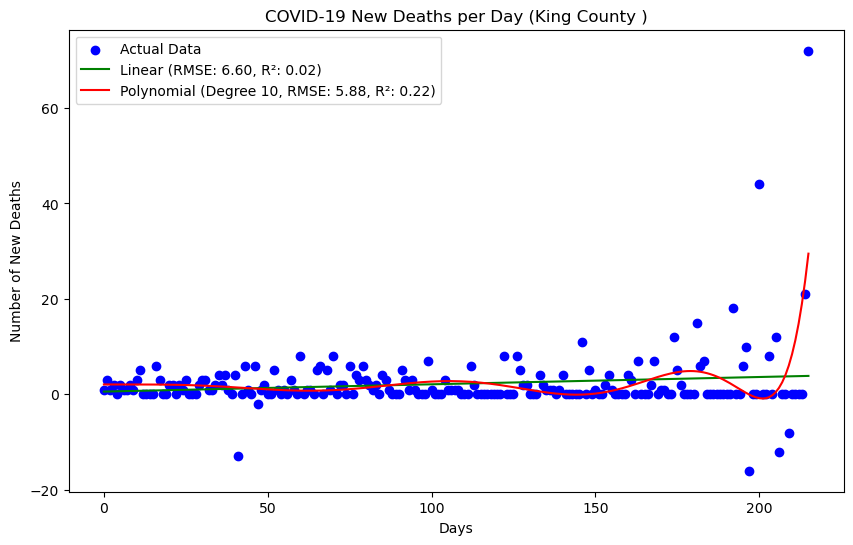

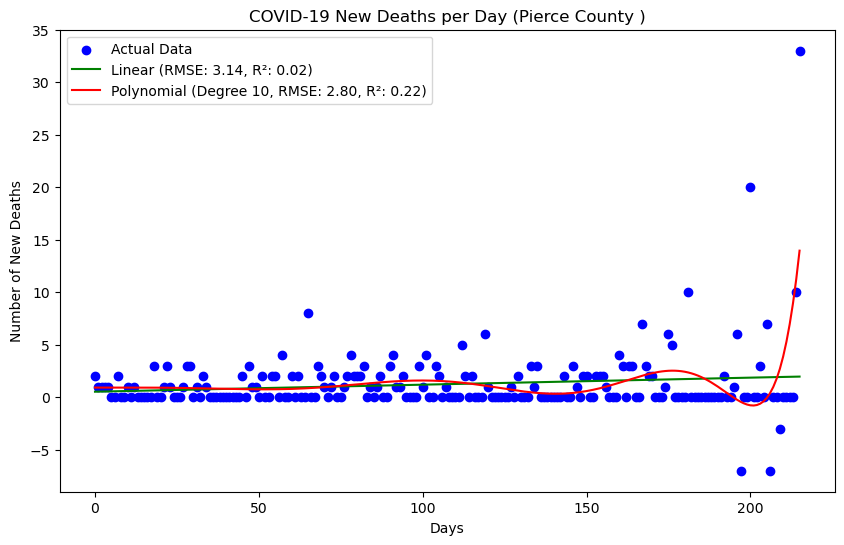

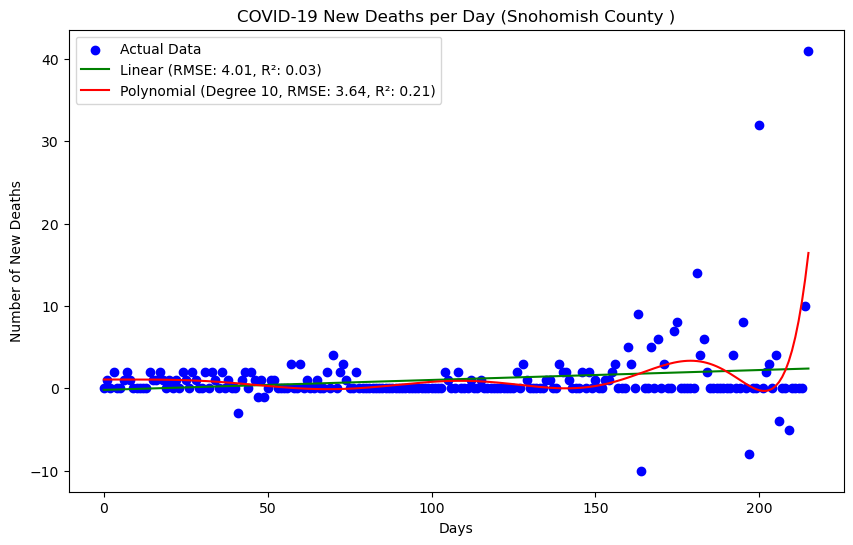

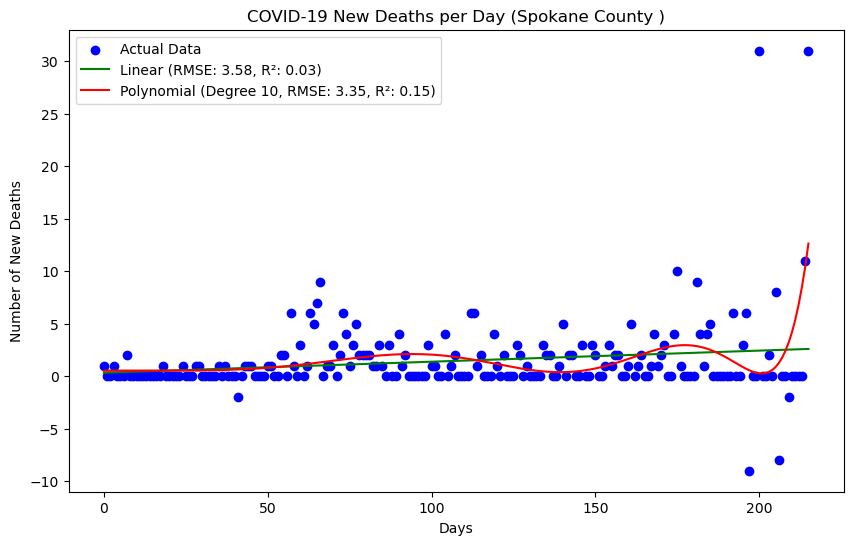

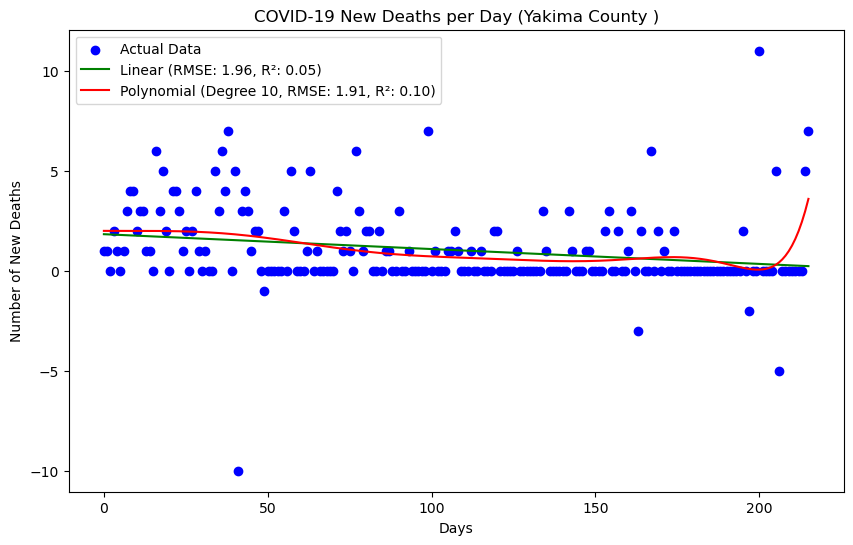

In [239]:
for county in top_counties:
    regression_d(county, degree=10)

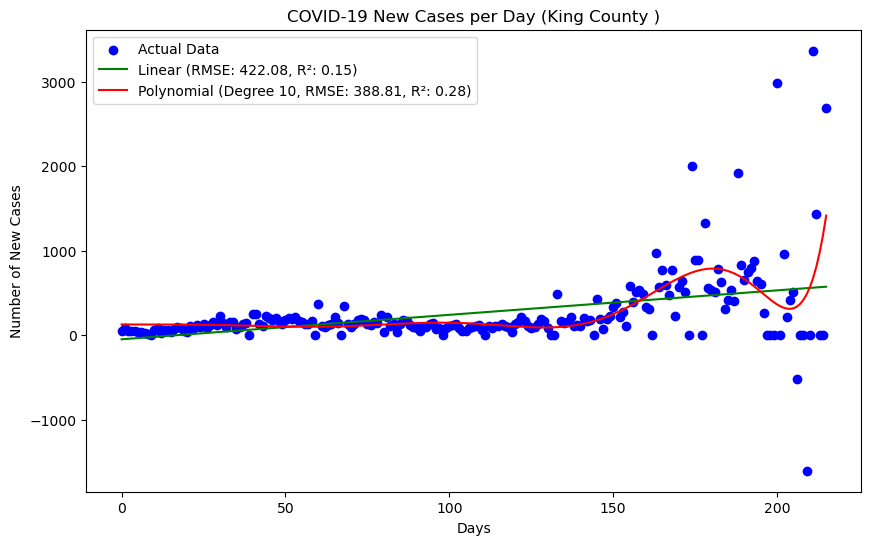

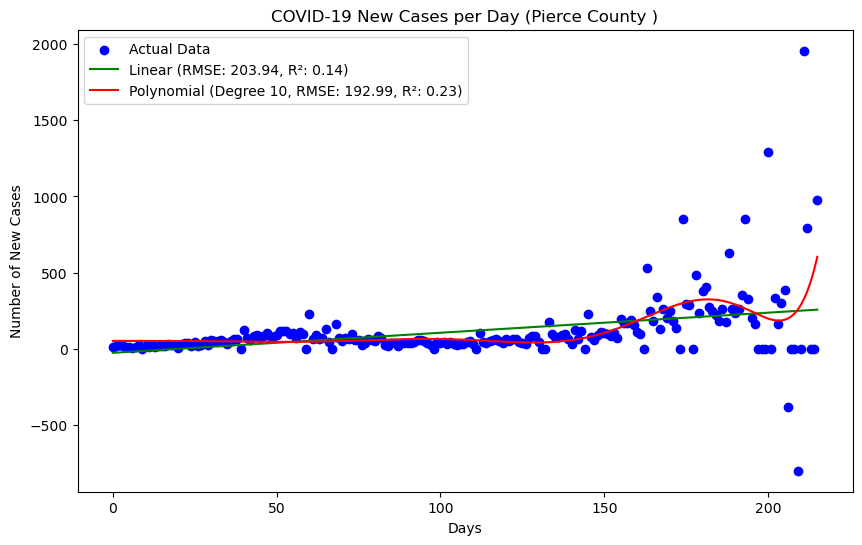

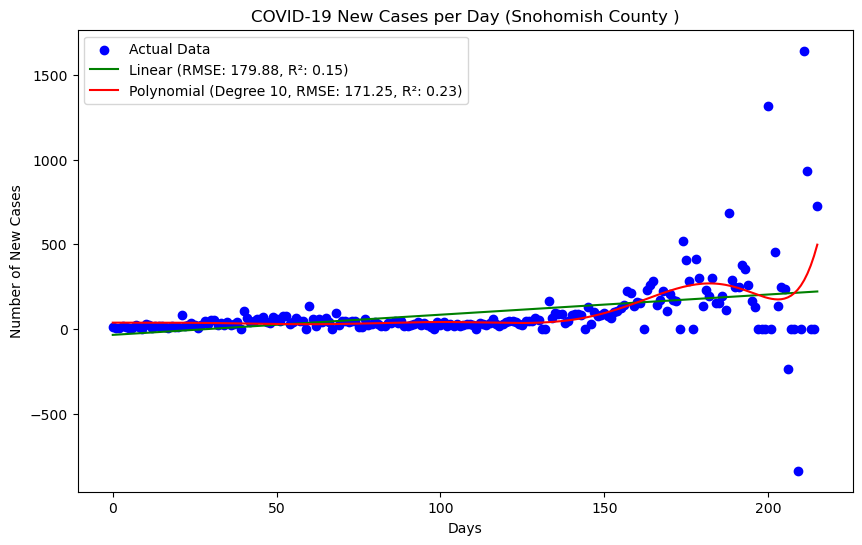

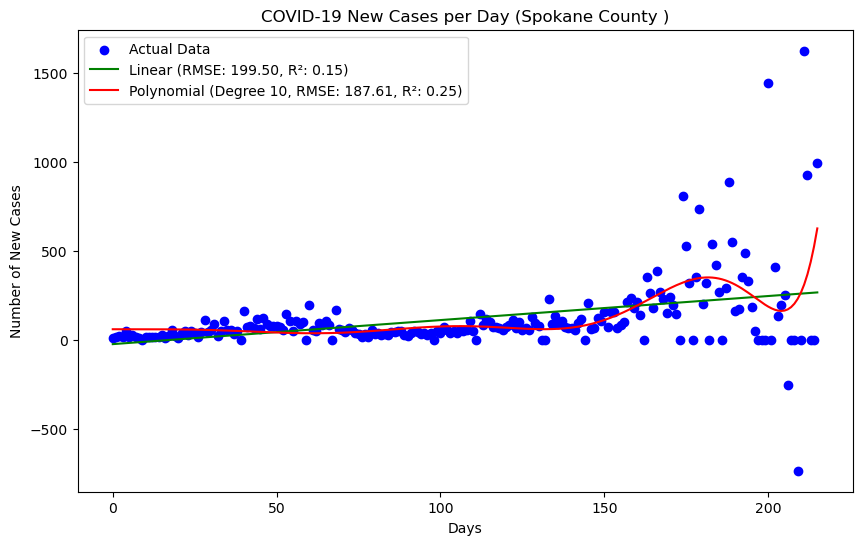

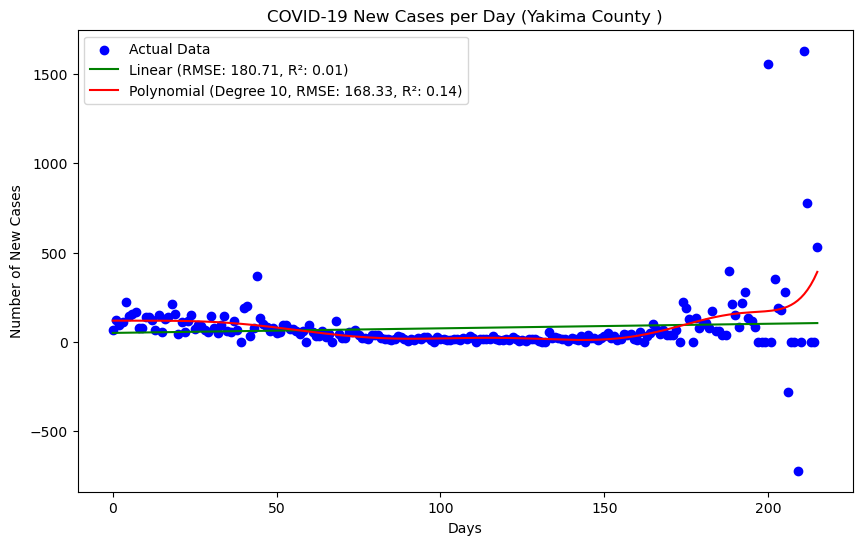

In [237]:
for county in top_counties:
    regression(county, degree=10) 

In [ ]:
for county in top_counties:
    regression_predictiond(county, degree=7) 

In [286]:
# for county in top_counties:
#     regression_predictionc(county, degree=7) 

Confidence interval 

In [280]:
# for county in top_counties:
#     regression_predictioncCInorm(county, degree=8) #15

In [282]:
# for county in top_counties:
#     regression_predictiondCInorm(county, degree=3) #15

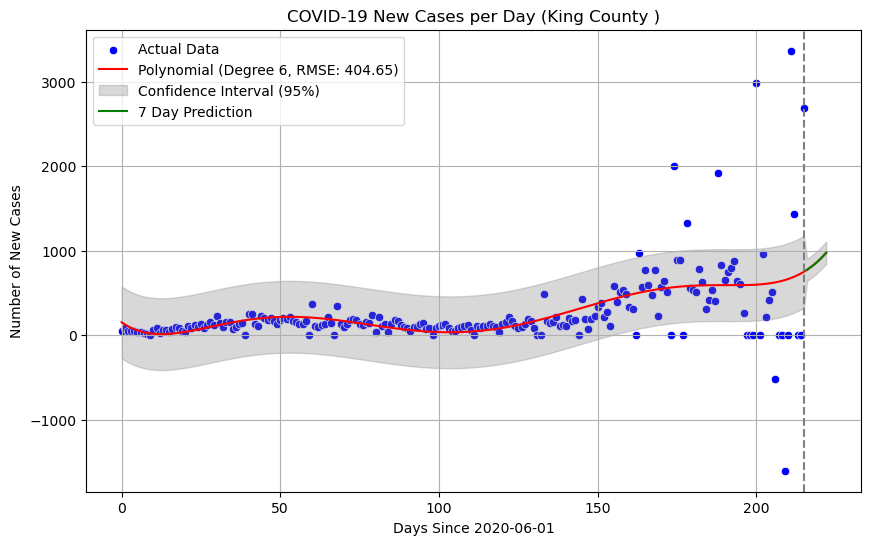

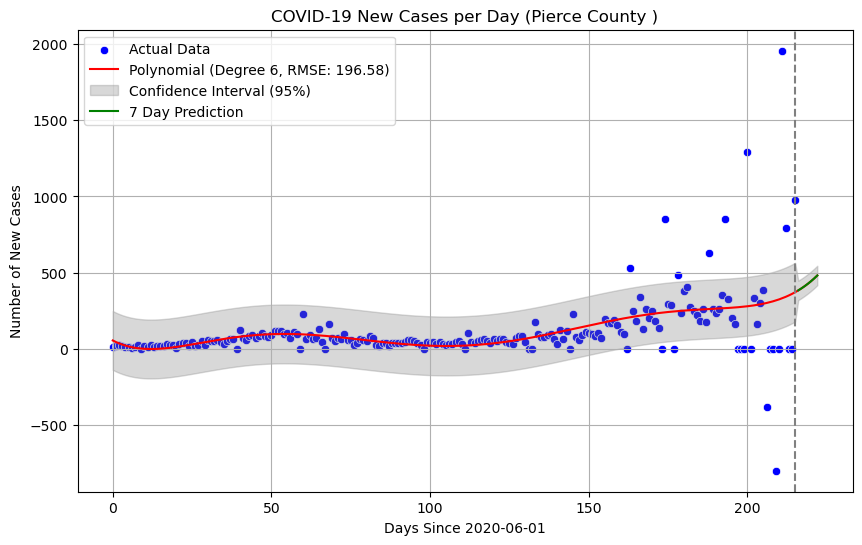

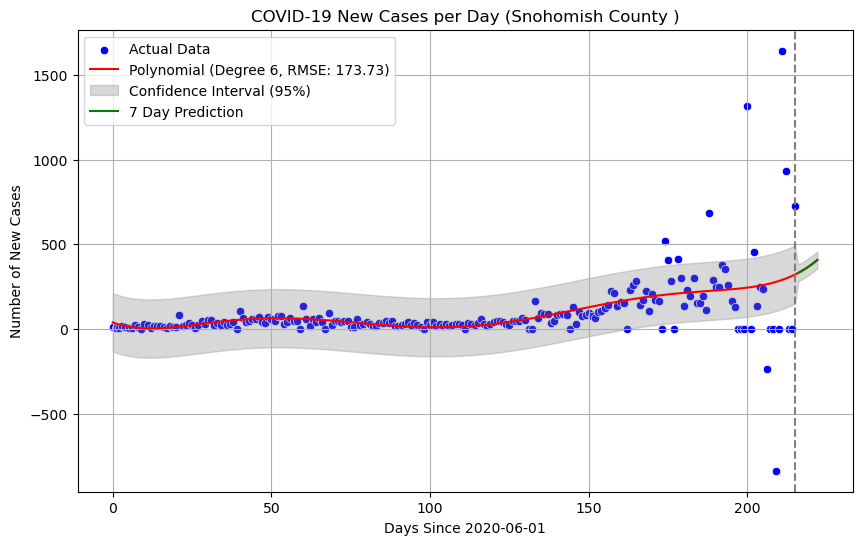

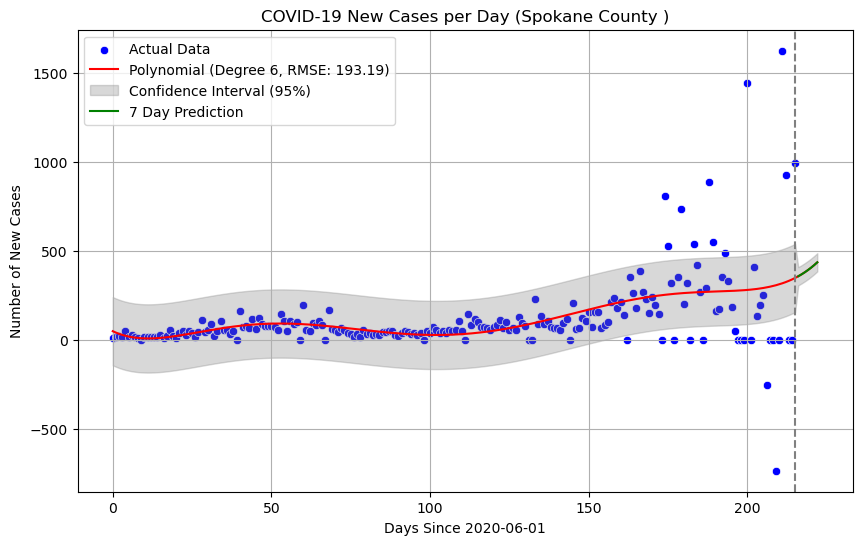

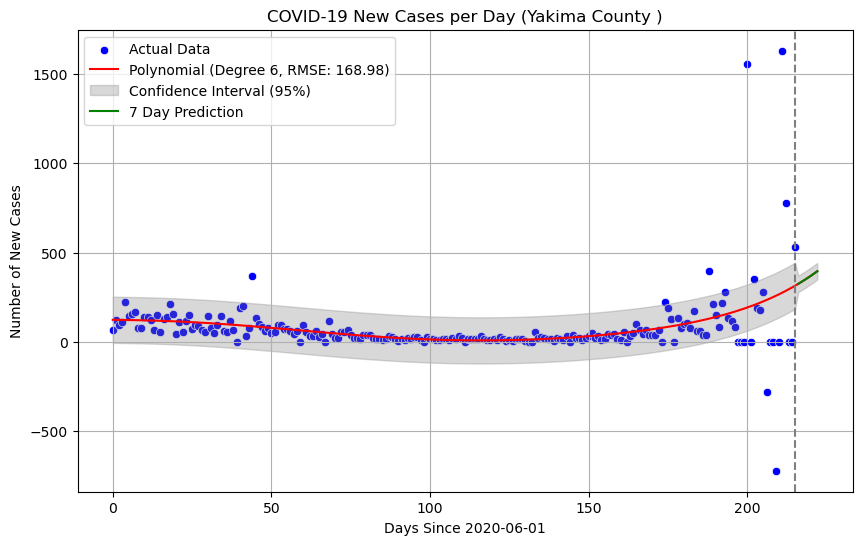

In [310]:
for county in top_counties:
    regression_predictioncCI(county, degree=6) 

From the plot, all five of the counties show similar predictions. The number of cases for all of the counties is predicted to increase in the next seven days.

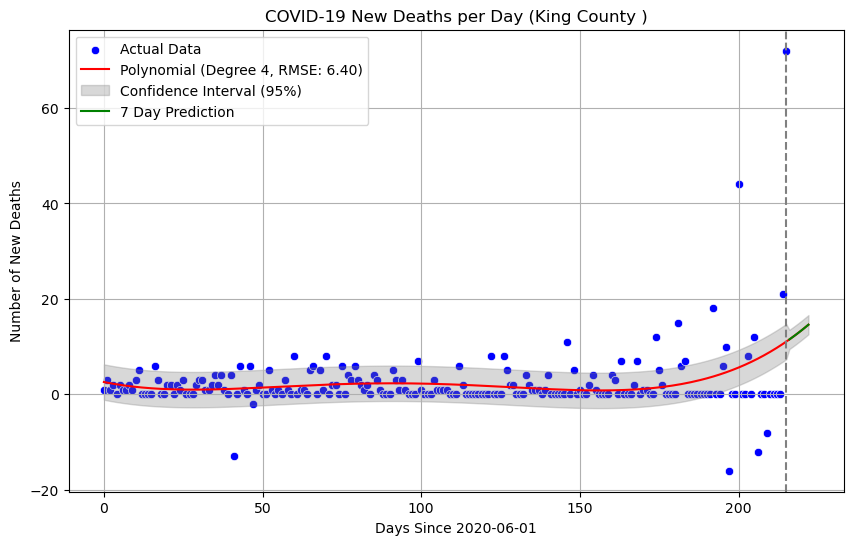

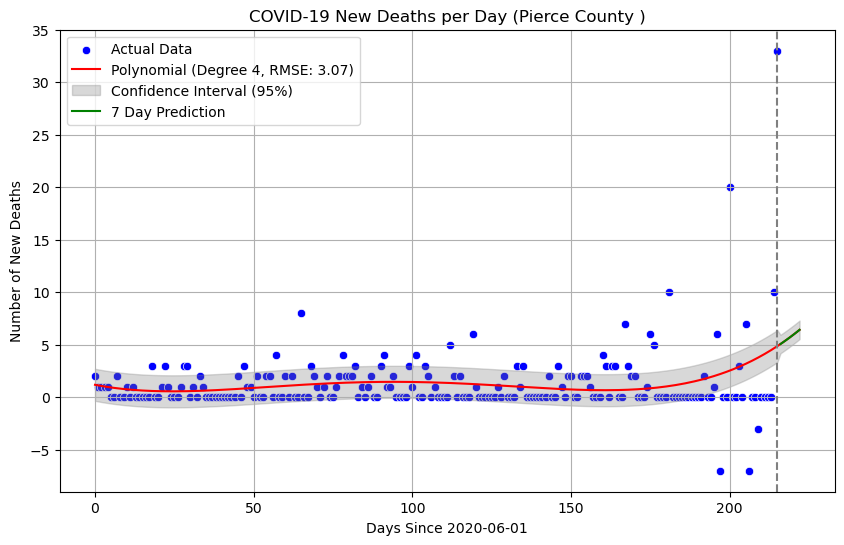

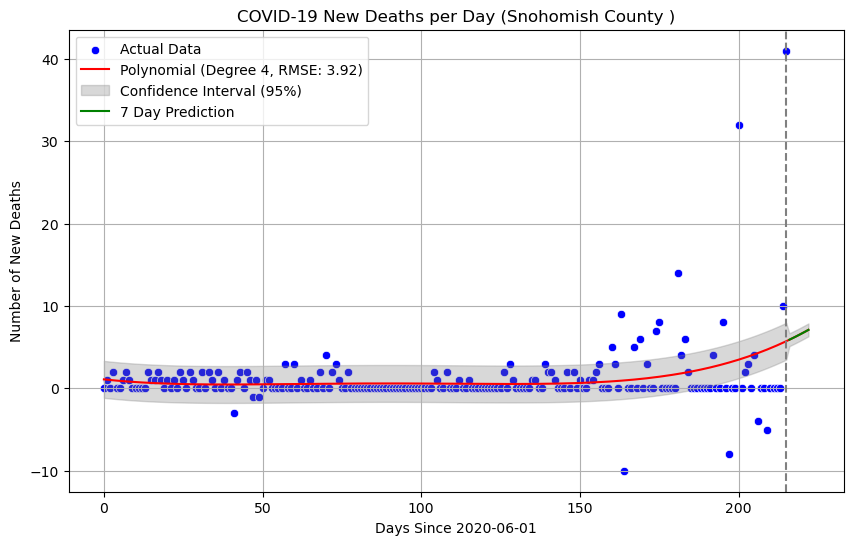

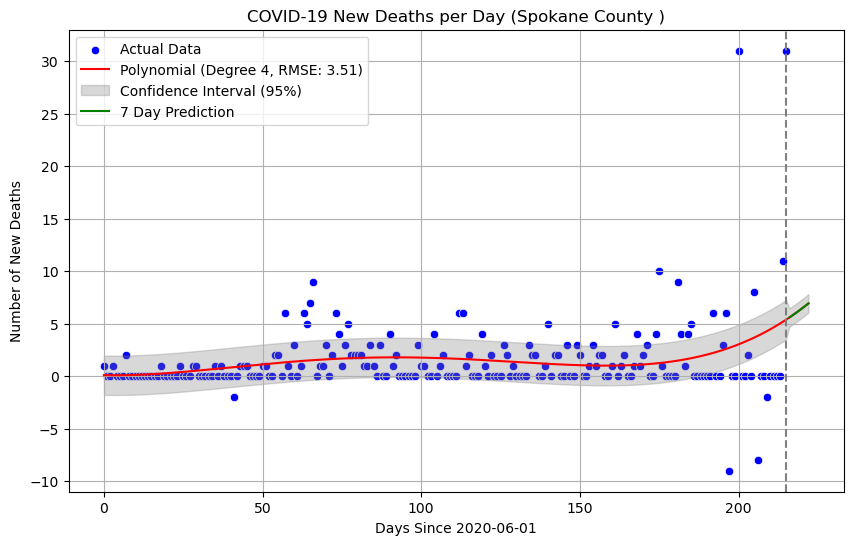

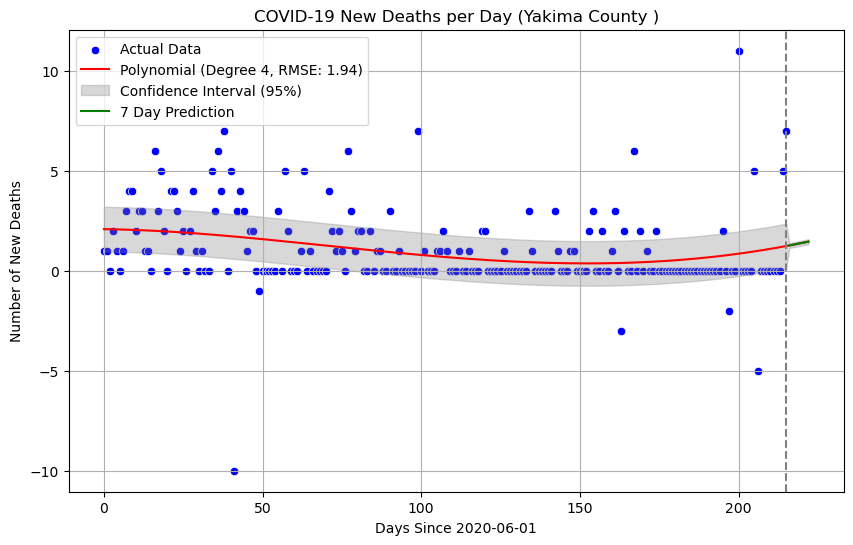

In [316]:
for county in top_counties:
    regression_predictiondCI(county, degree=4) 

From the prediction, four of the counties show similar predictions for the next seven day. Yakima County would be the least at risk for an increase in deaths in the next seven days. 

### Hypothesis

- Counties with higher population experience more COVID-19 cases.<br>
- Counties with more elderly people experienced more deaths.

The cases and deaths are cumalative so we will select the last column (2021-01-03) to get the latest case/death in our target range.

Select the first four columns and the last one and drop statewide unallocated

In [212]:
wa_county_last = wa_full.iloc[:, list(range(4)) + [-1]]
wa_county_last = wa_county_last.drop(index=0).reset_index(drop=True)
wa_county10 = pd.concat([wa_full_pop,wa_county_last[['2021-01-03']]], axis=1)

# Calculate cases per 10,000
wa_county10['Case Rate per 10,000'] = (wa_county10['2021-01-03'] / wa_county10['population']) * 10000

# wa_county10

Calculate the median which will be used to divide the counties into high- and low-population groups.

In [215]:
median_population = wa_county10['population'].median()
high_population_counties = wa_county10[wa_county10['population'] >= median_population]['Case Rate per 10,000']
low_population_counties = wa_county10[wa_county10['population'] < median_population]['Case Rate per 10,000']

In [217]:
t_stat, p_value = stats.ttest_ind(high_population_counties, low_population_counties)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: 0.4167614980079835
P-value: 0.6792609061864566


The p-value is greater than 0.05 so this means that there is no difference in COVID-19 rates in high population counties and low population counties.

Begin to test the second hypothesis

In [230]:
# Select the first four columns and the last one 
wa_dfull_deaths = wa_dfull.iloc[:, list(range(4)) + [-1]]

# Dropping statewide unallocated
wa_dfull_deaths = wa_dfull_deaths.drop(index=0).reset_index(drop=True)

# Concat needed information
wa_death_pop = pd.concat([wa_full_pops,wa_dfull_deaths[['2021-01-03']]], axis=1)
wa_death_pop_ed = pd.concat([wa_death_pop,wa_e_full[['DP05_0029E']]], axis =1)

Calculate the percent of the county that is elderly and the death rate per 10,000 people

In [223]:
wa_death_pop_ed['percent_elderly'] = ((wa_death_pop_ed['DP05_0029E'] / wa_death_pop_ed['population']) * 100).round(2)
wa_death_pop_ed['death_rate_per_10000'] = (wa_death_pop_ed['2021-01-03'] / wa_death_pop_ed['population']) * 10000

Separate the counties to those with high elderly population and those with low elderly population by using the median to help determine this. 

In [226]:
eld_median = wa_death_pop_ed['percent_elderly'].median()
high_eld_pop = wa_death_pop_ed[wa_death_pop_ed['percent_elderly']>= eld_median]['death_rate_per_10000']
low_eld_pop = wa_death_pop_ed[wa_death_pop_ed['percent_elderly'] < eld_median]['death_rate_per_10000']

t_dstat, p_dvalue = stats.ttest_ind(high_eld_pop, low_eld_pop)

print(f"T-statistic: {t_dstat}")
print(f"P-value: {p_dvalue}")

T-statistic: -1.8340913150622313
P-value: 0.07469276022244407


The p-value is greater than 0.05 which means that there is no siginificant difference between counties with more elderly population experienced more death than those with lower eldlerly population.  